In [5]:
import cartopy.crs as ccrs
import fsspec
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import planetary_computer
import pystac_client
import xarray as xr


In [6]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [7]:
longitude = 79.109
latitude = 22.746

geometry = {
    "type": "Point",
    "coordinates": [longitude, latitude],
}

search = catalog.search(
    collections="sentinel-5p-l2-netcdf",
    intersects=geometry,
    datetime="2023-04-02/2023-04-03",
    query={"s5p:processing_mode": {"eq": "OFFL"}, "s5p:product_name": {"eq": "ch4"}},
)
items = list(search.get_items())

print(f"Found {len(items)} items:")




Found 2 items:


In [8]:
f = fsspec.open(items[0].assets["ch4"].href).open()
ds = xr.open_dataset(f, group="PRODUCT", engine="h5netcdf")
ds

<xarray.Dataset>
Dimensions:                              (scanline: 4173, ground_pixel: 215,
                                          time: 1, corner: 4, layer: 12,
                                          level: 13)
Coordinates:
  * scanline                             (scanline) float64 0.0 ... 4.172e+03
  * ground_pixel                         (ground_pixel) float64 0.0 ... 214.0
  * time                                 (time) datetime64[ns] 2023-04-03
  * corner                               (corner) float64 0.0 1.0 2.0 3.0
  * layer                                (layer) float64 0.0 1.0 ... 10.0 11.0
  * level                                (level) float64 0.0 1.0 ... 11.0 12.0
    latitude                             (time, scanline, ground_pixel) float32 ...
    longitude                            (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                           (time, scanline) datetime64[ns] ...
    time_utc                             (time, scanline) object ...
    qa_value                             (time, scanline, ground_pixel) float32 ...
    methane_mixing_ratio                 (time, scanline, ground_pixel) float32 ...
    methane_mixing_ratio_precision       (time, scanline, ground_pixel) float32 ...
    methane_mixing_ratio_bias_corrected  (time, scanline, ground_pixel) float32 ...

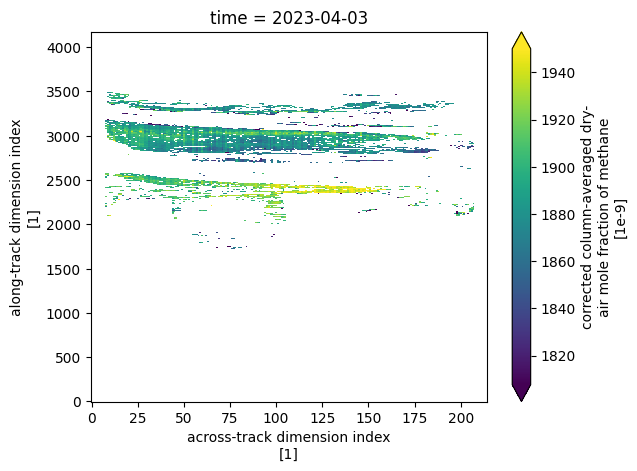

In [9]:
varname = "methane_mixing_ratio_bias_corrected"
data = ds[varname][0, :, :]
vmin, vmax = np.nanpercentile(data, [1, 99])
data.plot(vmin=vmin, vmax=vmax, cmap="viridis");

/opt/homebrew/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


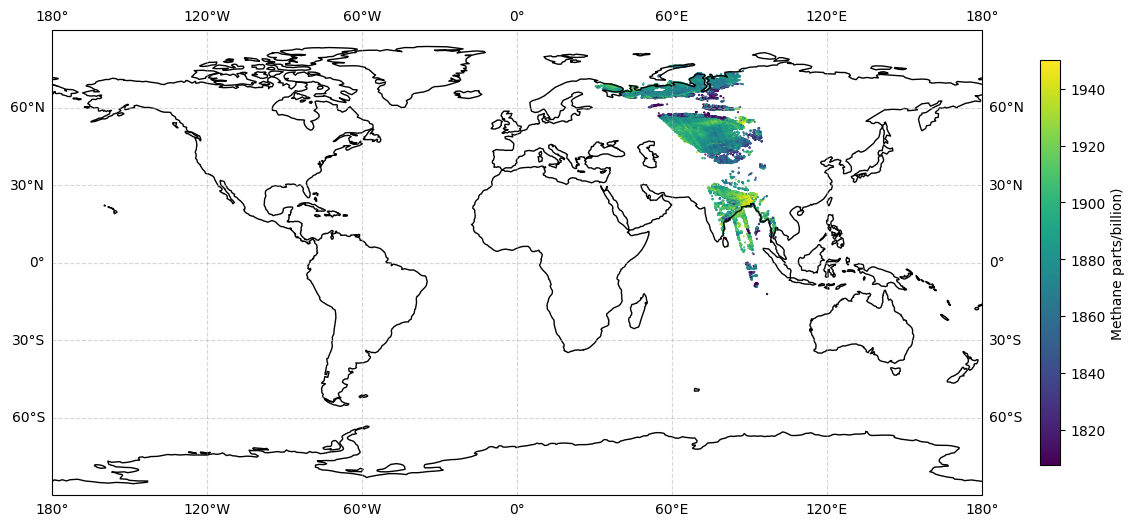

In [10]:
lon = ds["longitude"].values.squeeze()
lat = ds["latitude"].values.squeeze()
methane = data.values

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5, linestyle="--")
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
scatter = plt.scatter(
    lon,
    lat,
    c=methane,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    norm=norm,
    marker=".",
    s=1,
)
fig.colorbar(scatter, pad=0.05, shrink=0.35, label="Methane parts/billion)")
plt.show()